In [638]:
import pandas as pd
import seaborn as sns
sns.set()
import findspark
findspark.init()

from pyspark.sql import *
from pyspark.sql.functions import *
from pyspark.sql.functions import min
from pyspark.sql import SparkSession
import re
from pyspark import SparkContext
import matplotlib.pyplot as plt
%matplotlib inline

spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext

In [459]:
import time 
import datetime

In [460]:
def find_pt_att(ls, t):
    j = 0
    for i in range(len(ls)):
        if(t in ls[i]):
            j = i
            break
    return j

def extract_date(d):
    if(len(d) == 8):
        year = int(d[:4])
        month = int(d[4:6])
        day = int(d[6:8])

        return datetime.datetime(year, month, day)
    else:
        return datetime.datetime(1970, 1, 1)

def extract_invetors(ls):
    local_invetors = []
    for i in range(len(ls)):
        if("name" in ls[i]):
            name = ls[i].split("name")[1].split(":")[1].strip('""')
            local_invetors.append(name)
    return local_invetors

In [478]:
def create_obj(assignee, patent_number, filing_date, publication_date, invetors):
    l_inventors = []
    for i in range(len(invetors)):
        obj = (invetors[i],(
                assignee, (
                patent_number,(
                filing_date,
               publication_date))))
        l_inventors.append(obj)
    return l_inventors

In [572]:
log = sc.textFile("bq-results-20200528-134229-bs9htg9t5fck.json")

In [573]:
log = log.flatMap(lambda x: x.split("\n")).map(lambda x: x.lower())
log = log.collect()

In [574]:
len(log)

7266

In [601]:
def fun(x):
    
    l = x.split(",")
    assignee = l[0].split("assignee")[1]
    inventors = []
    
    stryker_bool = False
    mako_bool = False
    patent_number = find_pt_att(l, "publication_number")
    patent_number = l[patent_number]
    patent_number = patent_number.split(":")[1].strip('""')
    
    for i in range(len(l)):
        
        if("stryker" in l[i]):
            assignee = "Stryker"
            mako_bool = True
        if("mako" in l[i]):
            assignee = "Mako"
            stryker_bool = True

        if(stryker_bool and mako_bool):
#             print("here", patent_number)
            assignee = "Stryker-Mako"
    

    filing_date = find_pt_att(l, "filing_date")
    filing_date = l[filing_date]
#     print(patent_number, filing_date)
    filing_date = filing_date.split(":")[1].strip('""')
#     print("here")
    filing_date = extract_date(filing_date)

    publication_date = find_pt_att(l, "publication_date")
    publication_date = l[publication_date]
    publication_date = publication_date.split(":")[1].strip('""')
#     print("or here")
    publication_date = extract_date(publication_date)

    inventors = extract_invetors(l)
    inventors = create_obj(assignee, patent_number, filing_date, publication_date, inventors)
    
    if(assignee != "Mako" and assignee != "Stryker" and assignee != "Stryker-Mako"):
        print(assignee, patent_number)
    return inventors, assignee

new_inventors = []
number_of_mako_patents = 0
number_of_stryker_patents = 0
for i in range(len(log)):
    l_inventors, assignee = fun(log[i])
    
    if(assignee != "Mako" and assignee != "Stryker" and assignee != "Stryker-Mako"):
        print(assignee)
    if(assignee == "Mako"):
        number_of_mako_patents +=1
    elif(assignee == "Stryker"):
        number_of_stryker_patents +=1
    else:
        number_of_mako_patents +=1
        number_of_stryker_patents +=1
    new_inventors = new_inventors + l_inventors

In [602]:
inventors = sc.parallelize(new_inventors)

In [603]:
number_of_mako_patents

776

In [604]:
number_of_stryker_patents

6492

In [605]:
patent_apps_by_company

[('Stryker-Mako', <pyspark.resultiterable.ResultIterable at 0x1a35574950>),
 ('Mako', <pyspark.resultiterable.ResultIterable at 0x1a35574c10>),
 ('Stryker', <pyspark.resultiterable.ResultIterable at 0x1a35574650>)]

In [606]:
list(patent_apps_by_company[0][1])

[('moctezuma de la barrera jose luis',
  ('Stryker-Mako',
   ('us-9993273-b2',
    (datetime.datetime(2016, 8, 26, 0, 0),
     datetime.datetime(2018, 6, 12, 0, 0))))),
 ('perez timothy wade',
  ('Stryker-Mako',
   ('us-9993273-b2',
    (datetime.datetime(2016, 8, 26, 0, 0),
     datetime.datetime(2018, 6, 12, 0, 0))))),
 ('malackowski donald w',
  ('Stryker-Mako',
   ('us-9993273-b2',
    (datetime.datetime(2016, 8, 26, 0, 0),
     datetime.datetime(2018, 6, 12, 0, 0))))),
 ('moctezuma de la barrera jose luis',
  ('Stryker-Mako',
   ('us-2016361101-a1',
    (datetime.datetime(2016, 8, 26, 0, 0),
     datetime.datetime(2016, 12, 15, 0, 0))))),
 ('perez timothy wade',
  ('Stryker-Mako',
   ('us-2016361101-a1',
    (datetime.datetime(2016, 8, 26, 0, 0),
     datetime.datetime(2016, 12, 15, 0, 0))))),
 ('malackowski donald w',
  ('Stryker-Mako',
   ('us-2016361101-a1',
    (datetime.datetime(2016, 8, 26, 0, 0),
     datetime.datetime(2016, 12, 15, 0, 0)))))]

In [ ]:
number_of_mako_patents = list(patent_apps_by_comapny[0][1])

In [607]:
inventors = inventors.groupByKey().collect()

In [608]:
#Print number of Invetors
len(inventors)

2829

In [609]:
def divide_corps(inventor):
    inventions = list(inventor[1])
    corps = sc.parallelize(inventions).groupByKey().collect()
    new_form = (inventor[0], corps)
    return new_form

def filter_function(x):
    xs = x[1]
    k = []
    stryker_mako_bool = False
    for i in range(len(xs)):
        if(xs[i][0] == "Mako" or xs[i][0] == "Stryker"):
            k.append(xs[i])
        elif(xs[i][0] == "Stryker-Mako"):
            stryker_mako_bool = True
            
    if(stryker_mako_bool):
        return (x[0], xs)
    elif(len(k) == 2):
        return (x[0], xs)
    else:
        return ()

def filter_function_only_mako(x):
    xs = x[1]
    k = []
    stryker_mako_bool = False
    for i in range(len(xs)):
        if(xs[i][0] == "Mako"):
            k.append(xs[i])
        elif(xs[i][0] == "Stryker-Mako"):
            stryker_mako_bool = True
    
    if(len(k) == 1 or stryker_mako_bool):
        return (x[0], xs)
    else:
        return ()
    
def filter_function_only_stryker(x):
    xs = x[1]
    k = []
    stryker_mako_bool = False
    for i in range(len(xs)):
        if(xs[i][0] == "Stryker"):
            k.append(xs[i])
        elif(xs[i][0] == "Stryker-Mako"):
            stryker_mako_bool = True
    
    if(len(k) == 1 or stryker_mako_bool):
        return (x[0], xs)
    else:
        return ()

In [610]:
new_form_invetors = []
for i in range(len(inventors)):
    new_form_i = divide_corps(inventors[i])
    new_form_invetors.append(new_form_i)

In [611]:
rdd_inventors = sc.parallelize(new_form_invetors)

In [612]:
rdd_inventors.collect()

[('lemire guy',
  [('Stryker', <pyspark.resultiterable.ResultIterable at 0x1a2b701ad0>)]),
 ('dionne jean-paul',
  [('Stryker', <pyspark.resultiterable.ResultIterable at 0x1a2d60fb10>)]),
 ('culp jerry a',
  [('Mako', <pyspark.resultiterable.ResultIterable at 0x1a2d602b10>),
   ('Stryker', <pyspark.resultiterable.ResultIterable at 0x1a2d602d50>)]),
 ('beer joel n',
  [('Mako', <pyspark.resultiterable.ResultIterable at 0x1a2b41b590>),
   ('Stryker', <pyspark.resultiterable.ResultIterable at 0x1a2b41b9d0>)]),
 ('holmberg roy e',
  [('Stryker', <pyspark.resultiterable.ResultIterable at 0x1a2d623990>)]),
 ('lafleche patrick',
  [('Stryker', <pyspark.resultiterable.ResultIterable at 0x1a2d623c10>)]),
 ('wiederkehr andreas',
  [('Stryker', <pyspark.resultiterable.ResultIterable at 0x1a2d928350>)]),
 ('sylvestre pierre-luc',
  [('Stryker', <pyspark.resultiterable.ResultIterable at 0x1a2b62b350>)]),
 ('bielenstein oliver',
  [('Stryker', <pyspark.resultiterable.ResultIterable at 0x1a2b62b850>)

In [613]:
only_mako_inventors = rdd_inventors.map(filter_function_only_mako)

In [614]:
len(only_mako_inventors.filter(lambda x: x != ()).collect())

274

In [615]:
only_stryker_inventors = rdd_inventors.map(filter_function_only_stryker)

In [616]:
len(only_stryker_inventors.filter(lambda x: x != ()).collect())

2594

In [617]:
stryker_mako_inventors = rdd_inventors.map(filter_function)

In [618]:
stryker_mako_list = stryker_mako_inventors.filter(lambda x: x != ()).collect()

In [628]:
for i in range(len(stryker_mako_list)):
    name = stryker_mako_list[i][0]
    if(name == "mears dana c"):
        print(i)
        break

7


In [633]:
list(stryker_mako_list[7][1][1][1])

[('ca-1321520-c',
  (datetime.datetime(1989, 2, 2, 0, 0), datetime.datetime(1993, 8, 24, 0, 0))),
 ('ca-1328955-c',
  (datetime.datetime(1993, 3, 30, 0, 0), datetime.datetime(1994, 5, 3, 0, 0))),
 ('ca-1321677-c',
  (datetime.datetime(1987, 6, 19, 0, 0),
   datetime.datetime(1993, 8, 31, 0, 0))),
 ('ca-2008999-c',
  (datetime.datetime(1990, 1, 31, 0, 0), datetime.datetime(1995, 3, 7, 0, 0))),
 ('ca-1328707-c',
  (datetime.datetime(1993, 3, 30, 0, 0),
   datetime.datetime(1994, 4, 26, 0, 0))),
 ('ca-1328954-c',
  (datetime.datetime(1993, 3, 30, 0, 0), datetime.datetime(1994, 5, 3, 0, 0))),
 ('ca-1334072-c',
  (datetime.datetime(1993, 3, 30, 0, 0),
   datetime.datetime(1995, 1, 24, 0, 0))),
 ('ca-1328956-c',
  (datetime.datetime(1993, 3, 30, 0, 0), datetime.datetime(1994, 5, 3, 0, 0)))]

In [659]:
new_inventor_structure = []
before_acq = []
after_acq = []
for k in range(0, len(stryker_mako_list)):
    
    inventor = stryker_mako_list[k][0]
    if(len(list(stryker_mako_list[k][1])) == 3):
        
        stryker_mako_patents = list(stryker_mako_list[k][1][0][1])
        mako_patents = list(stryker_mako_list[k][1][1][1])
        stryker_patents = list(stryker_mako_list[k][1][2][1])
    else:
        mako_patents = list(stryker_mako_list[k][1][0][1])
        stryker_patents = list(stryker_mako_list[k][1][1][1])
        
    for i in range(0, len(mako_patents)-1):
        for j in range(0, len(mako_patents)-i-1):
            f_date_j = mako_patents[j][1][0]
            f_date_j1 = mako_patents[j+1][1][0]

            if f_date_j > f_date_j1:
                mako_patents[j], mako_patents[j+1] = mako_patents[j+1], mako_patents[j]



    for i in range(0, len(stryker_patents)-1):
        for j in range(0, len(stryker_patents)-i-1):

            f_date_j_stryker = stryker_patents[j][1][0]
            f_date_j1_stryker = stryker_patents[j+1][1][0]

            if f_date_j_stryker > f_date_j1_stryker:
                stryker_patents[j], stryker_patents[j+1] = stryker_patents[j+1], stryker_patents[j]
                
    if(len(list(stryker_mako_list[k][1]))):
        for i in range(0, len(stryker_mako_patents)-1):
            for j in range(0, len(stryker_mako_patents)-i-1):

                f_date_j_stryker = stryker_mako_patents[j][1][0]
                f_date_j1_stryker = stryker_mako_patents[j+1][1][0]

                if f_date_j_stryker > f_date_j1_stryker:
                    stryker_mako_patents[j], stryker_mako_patents[j+1] = stryker_mako_patents[j+1], stryker_mako_patents[j]
    
    
    first_date_mako = mako_patents[0][1][0]
    first_date_stryker = stryker_patents[0][1][0]
    
    num_mako_patents = len(mako_patents)
    num_stryker_patents = len(stryker_patents)
    mako_inventor_by_date = False
    mako_inventor_by_num_pt = False
    before_acquisition = False
    before_acq_stryker = True
    before_acq_stryker_arr = []
    after_acq_arr = []
    if(first_date_mako < first_date_stryker):
        mako_inventor_by_date = True
    if(num_mako_patents > num_stryker_patents):
        mako_inventor_by_num_pt = True
    if(first_date_mako < datetime.datetime(2014, 1, 1)):
        before_acquisition = True
        before_acq.append((inventor, (( mako_inventor_by_date, mako_inventor_by_num_pt)), (first_date_mako, first_date_stryker)))
    else:
        after_acq.append((inventor, (( mako_inventor_by_date, mako_inventor_by_num_pt)), (first_date_mako, first_date_stryker)))
        
    if(first_date_stryker < datetime.datetime(2014, 1, 1)):
        before_acq_stryker = True
        before_acq_stryker_arr.append((inventor, (( mako_inventor_by_date, mako_inventor_by_num_pt)), (first_date_mako, first_date_stryker)))
    else:
        after_acq_arr.append((inventor, (( mako_inventor_by_date, mako_inventor_by_num_pt)), (first_date_mako, first_date_stryker)))
#     print(first_date_mako, first_date_stryker, mako_inventor_by_date, before_acquisition)
#     print(num_mako_patents, num_stryker_patents, mako_invetor_by_num_pt)
    new_inventor_structure.append((inventor, (( mako_inventor_by_date, mako_inventor_by_num_pt, before_acquisition)), (first_date_mako, first_date_stryker)))

In [662]:
after_acq_arr

[]

In [ ]:
#Mako After ACQ - 3
#Outlier Stryker to MAKO - 1
#Outlier MAKO to STRYKER - 1
#(mears dana c) Outlier worked for Stryker first, but then worked for MAKO patent before acq, has more patents for MAKO than STRYKER
#34 - STRYKER to MAKO

In [621]:
print(len(before_acq), len(after_acq), len(new_inventor_structure))

1 38 39


In [627]:
new_inventor_structure

[('culp jerry a',
  (False, False, False),
  (datetime.datetime(2016, 5, 18, 0, 0),
   datetime.datetime(1993, 12, 15, 0, 0))),
 ('beer joel n',
  (False, False, False),
  (datetime.datetime(2016, 5, 18, 0, 0), datetime.datetime(2013, 8, 2, 0, 0))),
 ('viscardi david',
  (False, False, False),
  (datetime.datetime(2018, 11, 6, 0, 0),
   datetime.datetime(2018, 3, 20, 0, 0))),
 ('bowling david',
  (True, True, False),
  (datetime.datetime(2018, 6, 5, 0, 0), datetime.datetime(2019, 3, 4, 0, 0))),
 ('stawiaski jean',
  (False, False, False),
  (datetime.datetime(2019, 6, 14, 0, 0),
   datetime.datetime(2013, 8, 23, 0, 0))),
 ('bush jr charles l',
  (False, False, False),
  (datetime.datetime(2018, 5, 10, 0, 0),
   datetime.datetime(2006, 10, 5, 0, 0))),
 ('heinsohn jan',
  (False, False, False),
  (datetime.datetime(2018, 11, 6, 0, 0), datetime.datetime(2013, 3, 8, 0, 0))),
 ('mears dana c',
  (False, True, True),
  (datetime.datetime(2003, 10, 23, 0, 0),
   datetime.datetime(1987, 6, 19,

In [457]:
#After Acquisition Analysis
#8 - Mako
#3 - Stryker
#Mako but more for Stryker - 1
after_acq

[('viscardi david',
  (True, True),
  (datetime.datetime(2018, 3, 20, 0, 0),
   datetime.datetime(2018, 11, 6, 0, 0))),
 ('bowling david',
  (False, False),
  (datetime.datetime(2019, 3, 4, 0, 0), datetime.datetime(2018, 6, 5, 0, 0))),
 ('ghanam fadi',
  (True, True),
  (datetime.datetime(2018, 4, 19, 0, 0),
   datetime.datetime(2019, 6, 14, 0, 0))),
 ('flatt james',
  (True, True),
  (datetime.datetime(2014, 3, 15, 0, 0),
   datetime.datetime(2017, 10, 20, 0, 0))),
 ('woods philip robert',
  (True, True),
  (datetime.datetime(2016, 12, 6, 0, 0),
   datetime.datetime(2019, 5, 31, 0, 0))),
 ('gilhooley seamus',
  (True, True),
  (datetime.datetime(2016, 1, 18, 0, 0),
   datetime.datetime(2018, 9, 14, 0, 0))),
 ('davignon robert',
  (True, True),
  (datetime.datetime(2014, 5, 30, 0, 0), datetime.datetime(2014, 6, 5, 0, 0))),
 ('frank philip harris',
  (False, False),
  (datetime.datetime(2019, 4, 25, 0, 0),
   datetime.datetime(2014, 3, 14, 0, 0))),
 ('yadav rajan',
  (True, True),
  (da

In [456]:
#Before Acquisition Analysis
before_acq

[('culp jerry a',
  (True, True),
  (datetime.datetime(1993, 12, 15, 0, 0),
   datetime.datetime(2016, 5, 18, 0, 0))),
 ('beer joel n',
  (True, True),
  (datetime.datetime(2013, 8, 2, 0, 0), datetime.datetime(2016, 5, 18, 0, 0))),
 ('stawiaski jean',
  (True, True),
  (datetime.datetime(2013, 8, 23, 0, 0),
   datetime.datetime(2019, 6, 14, 0, 0))),
 ('bush jr charles l',
  (True, True),
  (datetime.datetime(2006, 10, 5, 0, 0),
   datetime.datetime(2018, 5, 10, 0, 0))),
 ('heinsohn jan',
  (True, True),
  (datetime.datetime(2013, 3, 8, 0, 0), datetime.datetime(2018, 11, 6, 0, 0))),
 ('dombrowski lori',
  (True, True),
  (datetime.datetime(2013, 12, 6, 0, 0), datetime.datetime(2019, 3, 1, 0, 0))),
 ('staunton douglas',
  (True, True),
  (datetime.datetime(2010, 9, 1, 0, 0),
   datetime.datetime(2017, 12, 13, 0, 0))),
 ('bowling david gene',
  (True, True),
  (datetime.datetime(2013, 8, 2, 0, 0), datetime.datetime(2016, 4, 7, 0, 0))),
 ('moctezuma de la barrera jose luis',
  (True, True)

In [647]:
total_revenue = {
    "Year" : [2012, 2013, 2014,  2015, 2016, 2017, 2018, 2019],
    "Total Revenue in Billions" : [8.657, 9.021, 9.675, 9.946, 11.235, 12.444, 13.601, 14.884]
}

In [636]:
mako_operations = {
    "Year" : [2013,  2015, 2017, 2018, 2019],
    "Mako Operations" : [30000, 50000, 125000, 200000, 300000]
}

In [642]:
df = pd.DataFrame(columns=["Total Revenue in Billions", 2012, 2013, 2014,  2015, 2016, 2017, 2018, 2019], 
                  data=[["Knee", 1.356, 1.371, 1.396, 1.403, 1.490, 1.595, 1.701, 1.815],
                        ["Hips", 1.233, 1.272,  1.291, 1.263, 1.283,  1.303, 1.336, 1.383],
                        ["Trauma", 0.989, 1.116, 1.230, 1.291, 1.364, 1.478, 1.580, 1.639],
                        ["Other", 0.245, 0.190, 0.236, 0.266, 0.285, 0.337, 0.374, 0.415]])

In [643]:
df_ortho = pd.DataFrame(columns=["Total Revenue in Billions", 2012, 2013, 2014,  2015, 2016, 2017, 2018, 2019], 
                  data=[["Orthopedics",3.823, 3.949, 4.153, 4.223, 4.422, 4.713, 4.991, 5.252],
                        ["MedSurg",3.265, 3.414,  3.781, 3.895, 4.894,  5.557, 6.045, 6.574],
                        ["Neurotechnology", 1.569, 1.658, 1.741, 1.828, 2.009, 2.174, 2.565, 3.058]])

In [644]:
df_percentage = pd.DataFrame(columns=["Total Revenue in % by sector", 2012, 2013, 2014,  2015, 2016, 2017, 2018, 2019], 
                  data=[["Orthopedics", 44, 44, 43, 43, 39, 38, 37, 35],
                        ["MedSurg", 38, 38,  39, 39, 43,  45, 44, 44],
                        ["Neurotechnology", 18, 18, 18, 18, 18, 17, 19, 21]])

In [650]:
df_tr = pd.DataFrame (total_revenue, columns = ['Year','Total Revenue in Billions'])

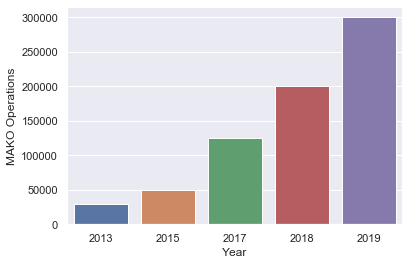

In [658]:
ax2 = sns.barplot(x = "Year", y = "Mako Operations", data = mako_operations)
ax2.set(xlabel='Year', ylabel='MAKO Operations')
plt.show()

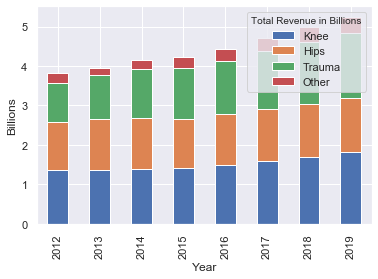

In [646]:
ax1 = df.set_index('Total Revenue in Billions').T.plot(kind='bar', stacked=True)
ax1.set(xlabel='Year', ylabel='Billions')
plt.show()

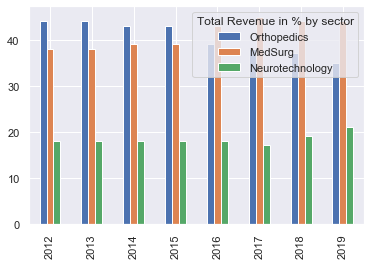

In [47]:
df_percentage.set_index('Total Revenue in % by sector').T.plot(kind='bar')